In [2]:
pip install -q graphlearning

In [27]:
import graphlearning as gl
import numpy as np
from scipy import sparse, linalg 
from scipy.special import softmax
from sklearn.decomposition import PCA as sklearn_pca
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#Active learning methods

In [4]:
#Function to randomly select points from each class and perform laplace and poisson learning
def initial_run(W, labels, num_train_per_class, random_state, plot=False):
  #Initialize training points
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  np.random.seed(random_state)
  train_ind = gl.randomize_labels(labels,num_train_per_class)
  np.random.seed()
  print("%f%% training data"%(100*len(train_ind)/num_pts))

  #Laplace Learning
  u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
  labels_laplace = np.argmax(u_laplace, axis=1)
  laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

  #Poisson Learning
  u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
  labels_poisson = np.argmax(u_poisson, axis=1)
  poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

  #Output results
  # if plot is True: 
  #   scatterplot(data, labels, train_ind, []) 
  #   laplace_poisson(data, labels_laplace, labels_poisson)
  print('Number of Labels,Accuracy')
  print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
  print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

  return train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson

In [5]:
#Function to perform simulation using random sampling
def random_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Random Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = np.ones(num_pts)
    obj_values[train_ind] = 0
    obj_values = obj_values/np.sum(obj_values)
    new_train_ind = np.random.choice(num_pts, size=1, replace=False, p=obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [6]:
def stats(uncertainty_values, filename):
  mean = np.mean(uncertainty_values)
  std = np.std(uncertainty_values)
  quantile1 = np.quantile(uncertainty_values, 0.25)
  median = np.quantile(uncertainty_values, 0.5)
  quantile3 = np.quantile(uncertainty_values, 0.75)
  min = np.min(uncertainty_values)
  max = np.max(uncertainty_values)
  with open('%s.csv'%filename, 'a') as f:
    f.writelines(f"mean=%.3f, std=%.3f, quantiles=(%.3f, %.3f, %.3f, %.3f, %.3f)"%(mean,std,min,quantile1,median,quantile3,max)+'\n')

def uncertainty(u, labeled_ind=None):
    num_pts = u.shape[0]
    num_classes = u.shape[1]
    u_probs = softmax(u, axis=1) 
    one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u, axis=1)]
    obj_values = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)
    if labeled_ind is None:
        return obj_values
    else:
        obj_values[labeled_ind] = obj_values.min()
    return obj_values

#Function to perform simulation using uncertainty sampling
def uncertainty_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Uncertainty Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = uncertainty(u_laplace, train_ind)
    stats(obj_values, 'uncertainty_sampling')
    new_train_ind = np.argmax(obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [7]:
#Function to initialize covariance matrix
def init_c(evals, evecs, labeled_ind=None):
    # do not include evals that are very close to 0!
    K = (evecs/evals[np.newaxis, :]) @ evecs.T
    if labeled_ind is None:
      return K
    else:  
      unlabeled_ind = list(filter(lambda x: x not in labeled_ind, range(evecs.shape[0])))
      return K[np.ix_(unlabeled_ind, unlabeled_ind)] - K[np.ix_(unlabeled_ind, labeled_ind)] @ linalg.inv(K[np.ix_(labeled_ind, labeled_ind)]) \
                                                              @ K[np.ix_(labeled_ind, unlabeled_ind)]
  
#Function to update the covariance matrix
def update_c(C, max_idx, labeled_ind):
    unlabeled_ind = np.delete(np.arange(C.shape[0]+len(labeled_ind)), labeled_ind)
    k = np.where(unlabeled_ind == max_idx)[0][0]
    C -= np.outer(C[:,k], C[:,k])/C[k,k]
    not_k = np.delete(np.arange(C.shape[0]), k)

    return C[np.ix_(not_k, not_k)]

#Function to calculate v-opt objective function values
def v_opt(C, labeled_ind=None):
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("V-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.1*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = v_opt(C, train_ind)
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [8]:
#Function to calculate sigma-opt objective function values
def sigma_opt(C, labeled_ind=None):
  unl_values = np.array([np.sum(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def sigmaopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Sigma-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.1*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = sigma_opt(C, train_ind) 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson)
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [9]:
#Function to calculate MC-VOpt objective function values
def mc_vopt(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-VOptimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.1*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = mc_vopt(C, u_laplace, train_ind)
    stats(unc_values, 'mc_vopt') 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [10]:
#Function to calculate MC-VOpt objective function values
def model_change(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-Laplace")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.1*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = model_change(C, u_laplace, train_ind) 
    stats(unc_values, 'mc_laplace')
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [24]:
#Function to plot the laplace and poisson accuracy
def lineplot(num_train, random_acc, uncertainty_acc, vopt_acc, sigmaopt_acc, mcvopt_acc, method, filename=None):
  plt.figure(figsize=(10,5))
  plt.plot(num_train, vopt_acc, 'bv-', markersize=10, label='V-Opt')
  plt.plot(num_train, sigmaopt_acc, 'rs-', markersize=10, label='Sigma-Opt')
  plt.plot(num_train, random_acc, 'gx-', markersize=10, label='Random')
  plt.plot(num_train, uncertainty_acc, 'c+-', markersize=10, label='Uncertainty')
  plt.plot(num_train, mcvopt_acc, 'k*-', markersize=10, label='MC-VOpt')
  plt.xlabel('number of labeled points')
  plt.ylabel('%s Learning Accuracy'%method)
  plt.legend()
  if filename is not None: plt.savefig('%s.png'%filename)
  plt.show()
  print("rand: %.3f"%random_acc.max(), "unc: %.3f"%uncertainty_acc.max(), "vopt: %.3f"%vopt_acc.max(), "sopt: %.3f"%sigmaopt_acc.max(), "mc-vopt: %.3f"%mcvopt_acc.max())

#Active learning on MNIST

In [12]:
## Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50, similarity='angular')
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [33]:
#Function to perform PCA on image
def PCA(data, component=False):

  #Perform PCA with 1200 components
  pca = sklearn_pca(n_components=data.shape[1]//2)
  pca.fit(data)
  variance = 100*(pca.explained_variance_ratio_)

  #Get the number of components with variance greater than 0.005%
  num_components = len(variance[variance>5e-3])

  #Perform PCA with the new number of components
  pca = sklearn_pca(n_components=num_components)
  pca_data = pca.fit_transform(data)
  print("Total Variation (%d components): "%num_components, np.sum(pca.explained_variance_ratio_))
  print("shape:",pca_data.shape)
  
  if component==True:
    return pca_data, num_components
  return pca_data

In [39]:
#Load labels, knndata, an build 10-nearest neighbor weight matrix
data = gl.load_dataset('mnist')
data = np.vstack((data[:1000], data[-1000:]))
labels = gl.load_labels('mnist')
labels = np.hstack([labels[:1000],labels[-1000:]])

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (2000, 2000)
Sigma-Optimality
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,66.683
Poisson: 10,81.809
0.0009006238570171459 247968.66865722951
Number of Labels,Accuracy
Laplace: 11,41.378
Poisson: 11,82.906
2.238115245058382 111218.29304614317
Number of Labels,Accuracy
Laplace: 12,49.245
Poisson: 12,82.746
0.18502978116311064 79563.83590428291
Number of Labels,Accuracy
Laplace: 13,52.944
Poisson: 13,82.587
0.5566153634531484 58098.70286901459
Number of Labels,Accuracy
Laplace: 14,55.035
Poisson: 14,83.434
0.014658731562617917 49803.4597193959
Number of Labels,Accuracy
Laplace: 15,56.675
Poisson: 15,82.720
0.02069374955804068 37794.29744313422
Number of Labels,Accuracy
Laplace: 16,63.962
Poisson: 16,83.014
0.00027032017009411783 31239

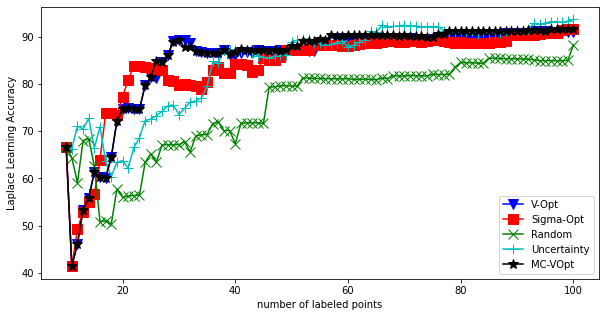

rand: 88.211 unc: 93.632 vopt: 91.138 sopt: 91.583 mc-vopt: 91.592


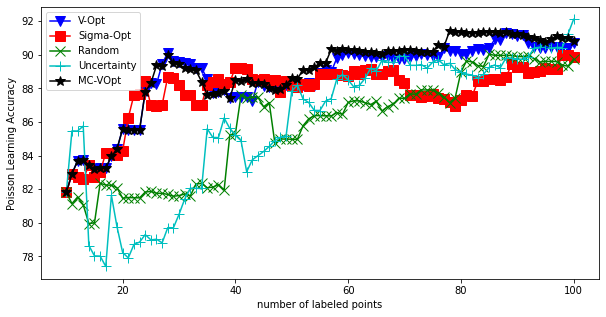

rand: 90.026 unc: 92.105 vopt: 91.266 sopt: 90.005 mc-vopt: 91.415


In [37]:
#1. Raw Output
W = weight_matrix(data)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 100)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 100)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 100)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 100)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 100)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='Raw_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='Raw_Poisson')

Total Variation (388 components):  0.9966471369912853
shape: (2000, 388)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=True
k=8 connected=True
weight matrix shape:  (2000, 2000)
V-Optimality
0.500000% training data
Number of Labels,Accuracy
Laplace: 10,66.583
Poisson: 10,78.492
14.835426736580173 210.93366114595082
Number of Labels,Accuracy
Laplace: 11,34.037
Poisson: 11,79.990
14.816753315793383 192.54264052769048
Number of Labels,Accuracy
Laplace: 12,37.123
Poisson: 12,79.728
14.814528448119013 184.10680001810346
Number of Labels,Accuracy
Laplace: 13,44.690
Poisson: 13,79.114
14.7901531264945 160.85641527818325
Number of Labels,Accuracy
Laplace: 14,52.518
Poisson: 14,79.053
14.793351547755382 154.3706968052073
Number of Labels,Accuracy
Laplace: 15,58.640
Poisson: 15,78.892
14.785413579750328 118.6873663318166
Number of Labels,Accuracy
La

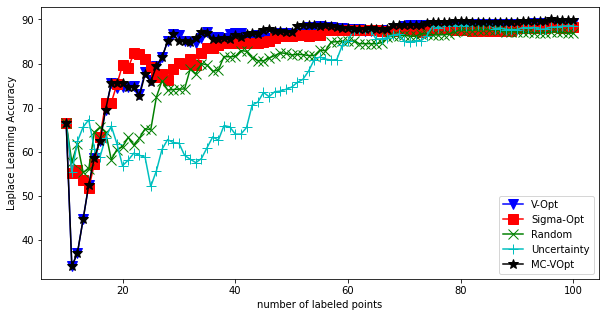

rand: 87.683 unc: 88.930 vopt: 89.274 sopt: 88.217 mc-vopt: 90.021


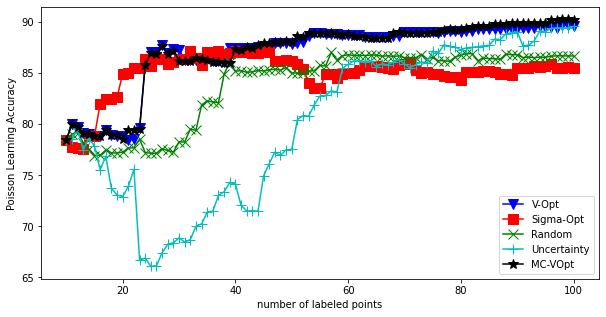

rand: 87.030 unc: 89.579 vopt: 89.695 sopt: 87.213 mc-vopt: 90.273


In [38]:
#2. PCA on Raw output
pca_data = PCA(data)
W = weight_matrix(pca_data)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 100)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 100)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 100)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 100)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 100)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='Raw_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='Raw_Poisson')